# Tutorial 4: Index Compression

1. Heaps' Law and Zipf's Law


Define and Contrast Heaps' Law and Zipf's Law. In the context of large text collections, what does each of these empirical laws model, and what is the primary quantity each law is concerned with?


#### Solution: 


a) Heaps' Law: Estimating Vocabulary Size

Heaps' Law is an empirical formula used to estimate the vocabulary size ($M$) (the number of distinct terms) of a text collection as a function of the total number of tokens ($T$) in the collection.

The Formula $M = k T^b$ $M$: The size of the vocabulary (number of unique terms).

$T$: The total number of tokens (word occurrences) in the collection. 

$k$ and $b$: Parameters determined empirically for a given collection. Typical values are $30 \le k \le 100$ and $b \approx 0.5$ (e.g., 0.49 for Reuters-RCV1).


 Zipf's Law: Modeling Term Frequency Distribution
 
 Zipf's Law is a statistical model that describes how terms are distributed by frequency across a collection. It states that the collection frequency ($cf_i$) of the $i^{th}$ most common term is inversely proportional to its rank $i$.
 
 Formula $cf_i \propto \frac{1}{i}$ 
 
 $cf_i$: The collection frequency (total number of occurrences) of the term with rank $i$.
 
 $i$: The rank of the term when terms are ordered by decreasing frequency ($i=1$ is the most frequent term).In practical terms, if the most frequent term occurs $N$ times, the second most frequent term occurs about $N/2$ times, the third $N/3$, and so on. This rapid decrease in frequency with rank is characteristic of a power law distribution.

In the images below, M is the number of normalized non-positional tokens. T is the number of positinal tokens which means we are counting all the times they occur in the document/collection. The first image is Heaps' Law, the second is Zipf's Law.

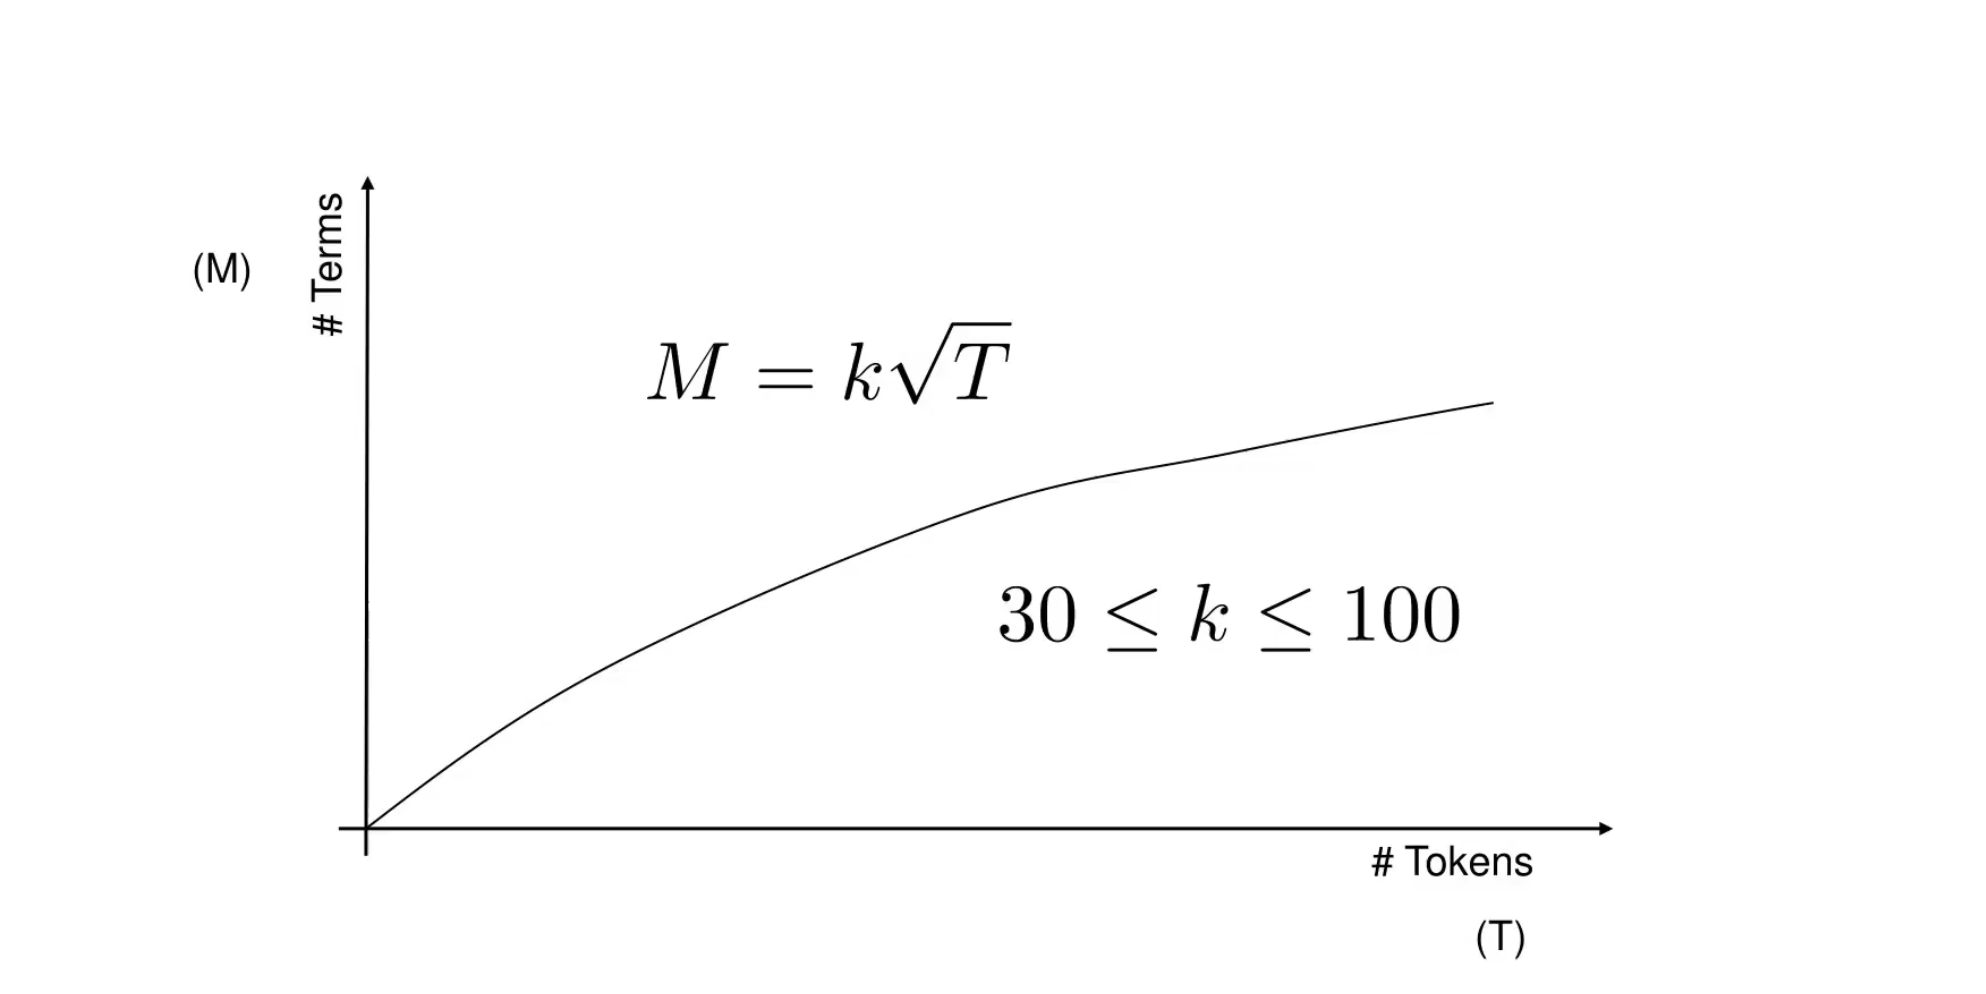

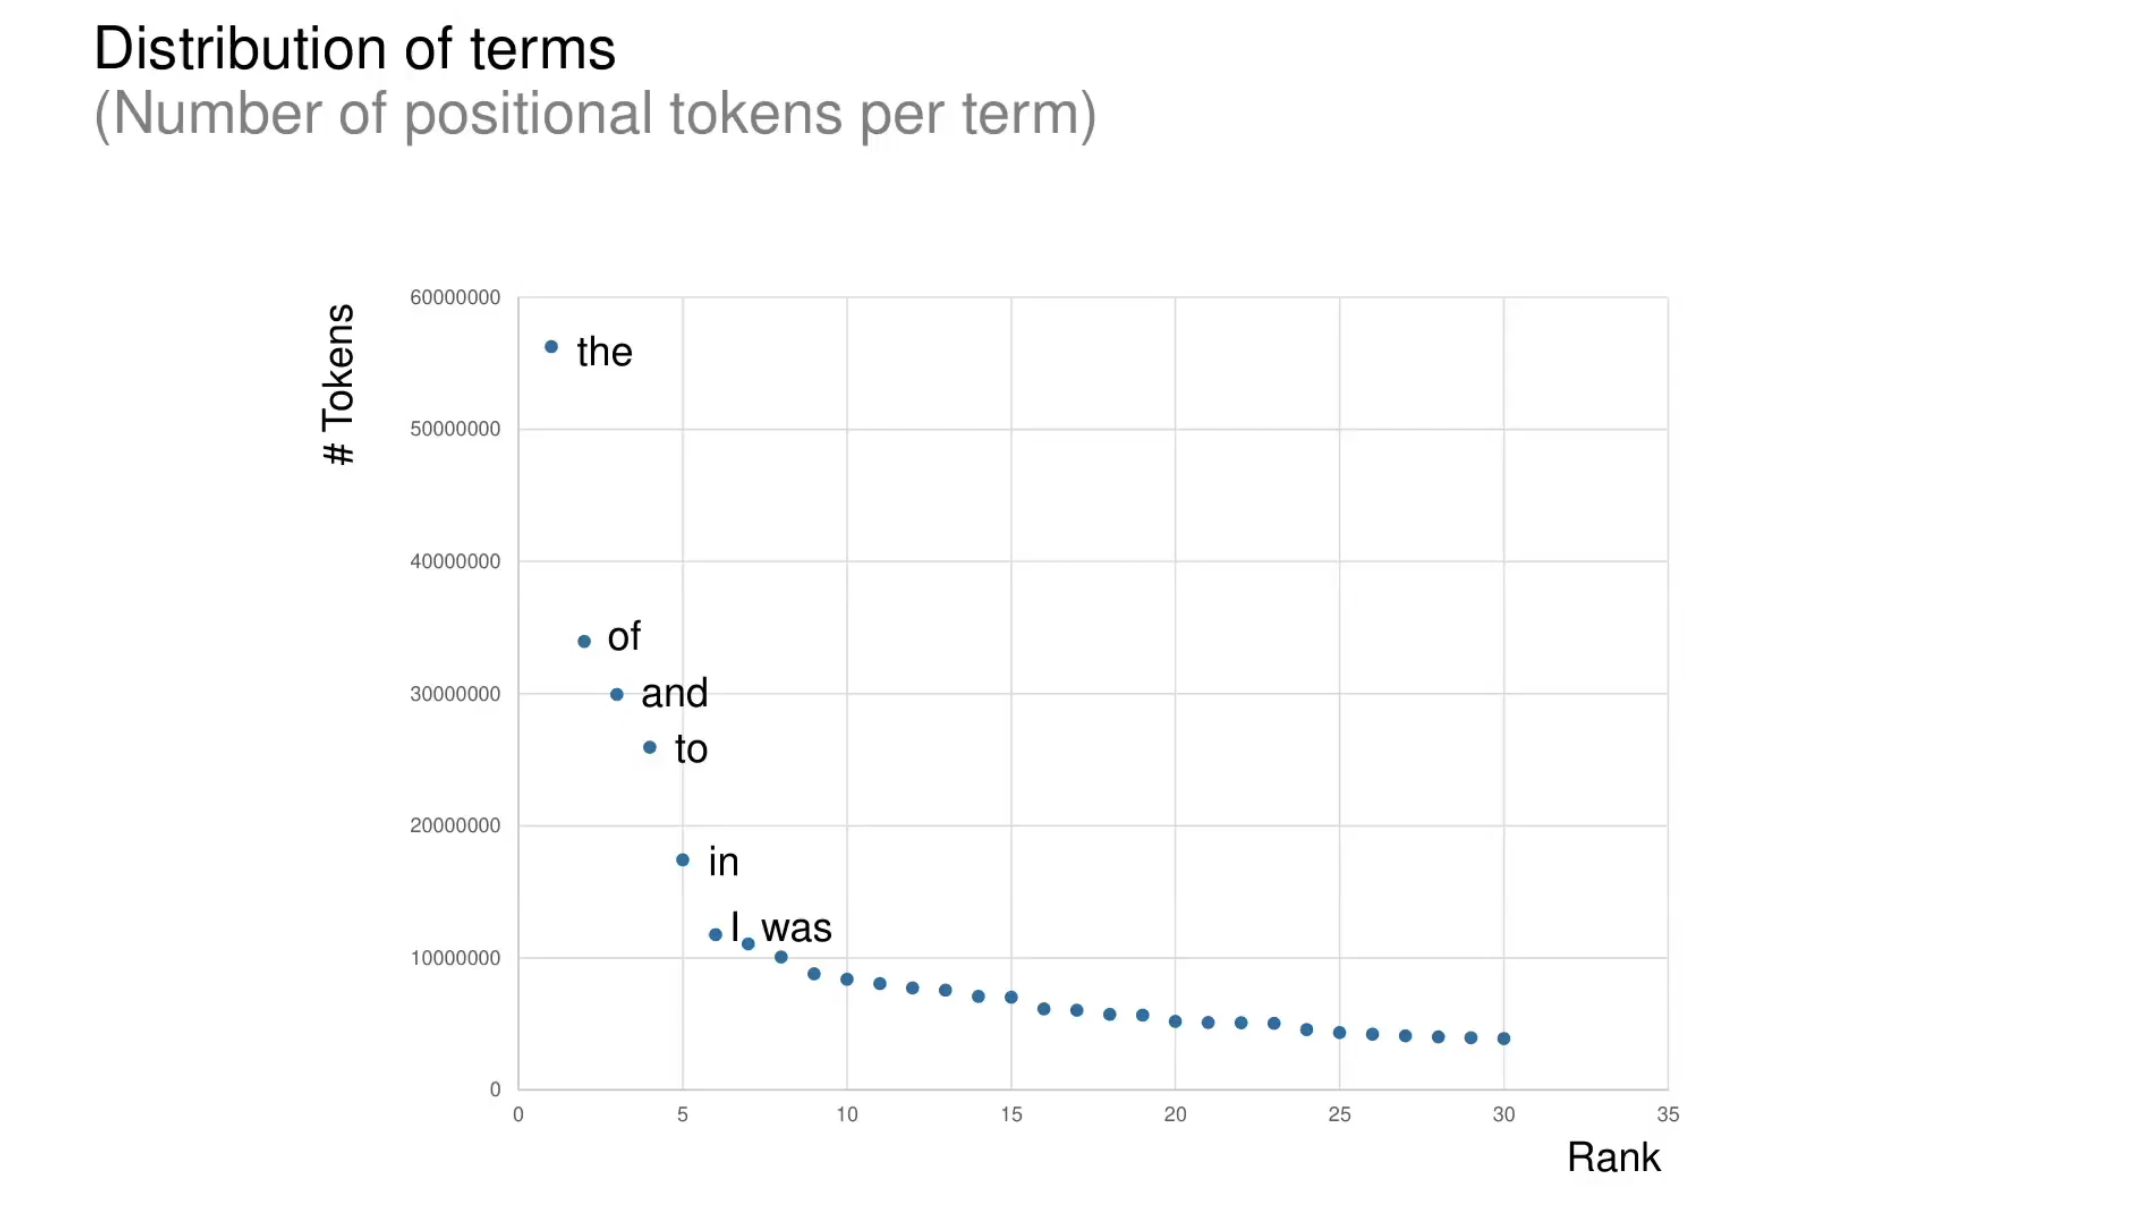

2. a) Explain what is variable byte encoding and how you would encode the numbers 1, 10, 50, and 130.

b) Decode the sequence 00000011 10000100



#### Solution: 

a) Variable Byte (VB) encoding is a simple and efficient method for compressing postings lists by representing the gaps between document IDs using a variable number of bytes. Basics of Variable Byte (VB) EncodingVB encoding uses an integral number of bytes to encode an integer (a gap), using 7 bits per byte for the actual number and 1 bit as a flag. 

Payload and Continuation Bit

Payload (7 bits): The lower 7 bits of a byte are used to encode part of the gap value. Since a byte has 8 bits, this leaves $2^7 = 128$ possible values for this portion of the number.


Continuation Bit (1 bit): The most significant bit (MSB, the first bit) of the byte is a continuation bit. It is set to 0 if the number continues in the next byte. It is set to 1 for the last byte of the encoded number.

Gap: 1 , Binary (7-bit Payload): 0000001 , Continuation Bit:  1, VB Code (8 bits): 10000001

Gap: 10 , Binary (7-bit Payload): 0001010 , Continuation Bit:  1, VB Code (8 bits): 10001010

Gap: 50 , Binary (7-bit Payload): 0110010 , Continuation Bit:  1, VB Code (8 bits): 10110010


Two-Byte Encoding (Gaps $\le 16,383$)

When a gap is larger than 127, two or more bytes are needed. The first byte(s) will have their continuation bit set to 0. The total capacity is $128 \times 128 - 1 = 16,383$. 

Let's encode the gap 130:

Divide by 128: $130 = 1 \times 128 + 2$.

Last Byte (Remainder 2): The remainder is $2$. 

This is the last byte, so the MSB is 1.

Payload: $0000010_2$

Last Byte: 10000010

First Byte (Quotient 1): The quotient is $1$. This is not the last byte, so the continuation bit is 0.

Payload: $0000001_2$

First Byte: 00000001

The VB code for 130 is 00000001 10000010.

b) If you read the sequence 00000011 10000100:

First Byte (00000011): continuation bit is 0; payload is $3$.

Second Byte (10000100): MSB is 1; payload is $4$. 

This signals the end.

Calculate $G$: Combine the payloads using $G = (\text{Payload}_1 \times 128) + \text{Payload}_2$.$G = (3 \times 128) + 4 = 384 + 4 = 388$. The decoded gap is $\mathbf{388}$.

3. a) Explain what is gamma encoding and encode 13 using Gamma encoding.

b) Decode the following stream of $\gamma$-encoded bits into its sequence of three positive integer gaps.$$\text{Bit Stream: } \mathbf{10} \mathbf{0} \mathbf{110} \mathbf{00} \mathbf{1110} \mathbf{010}$$



 #### Solution: 
 
 a) Gamma ($\gamma$) encoding is a bit-level compression method introduced to achieve better compression ratios than Variable Byte (VB) encoding by operating on the finer granularity of bits, rather than whole bytes.

 $\gamma$ encoding splits the representation of a gap ($G$) into two parts: the length of the number and its offset (or remainder).




Encoding 13:

Offset (The Value):
The offset is the binary representation of $G$ with the leading 1 removed. If $G = 13$, the binary is $1101_2$. The offset is $101_2$. (Length = 3 bits). 

Length (The Prefix):

The length is the number of bits in the offset ($\lfloor \log_2 G \rfloor$), encoded in unary code (a string of $N$ ones followed by a single zero). Since the offset length is 3, the unary code is $1110_2$. 

$\gamma$ Code:

The final $\gamma$ code is the length followed by the offset.For $G=13$, the $\gamma$ code is $1110 \ 101$.The total length of a $\gamma$ code is $2 \times \lfloor \log_2 G \rfloor + 1$ bits, which is highly efficient, approaching the theoretical optimum of $\log_2 G$ bits for large numbers.

b) Decoding $$\text{Bit Stream: } \mathbf{10} \mathbf{0} \mathbf{110} \mathbf{00} \mathbf{1110} \mathbf{010}$$

Read Unary Code: Start reading bits until the first 0: 10.

The count of 1s is 1. Thus, the length $L=1$.

Read Offset: Read the next $L=1$ bit: 0.

Reconstruct: Prepend '1' to the offset: $10_2 = \mathbf{2}$.

Gap 2: Read Unary Code: Start reading bits from where the last code ended: 110. The count of 1s is 2. Thus, the length $L=2$.

Read Offset: Read the next $L=2$ bits: 00.

Reconstruct: Prepend '1' to the offset: $100_2 = \mathbf{4}$.

Gap 3: Read Unary Code: Read from where the last code ended: 1110.

The count of 1s is 3. Thus, the length $L=3$.

Read Offset: Read the next $L=3$ bits: 010.

Reconstruct: Prepend '1' to the offset: $1010_2 = \mathbf{10}$.